# Immune receptor analysis using amino acid kmers embeddings

- **Input**
- **Data preparation**
- **CMV-EBV classification without V segments**
 - SVM (0.711 acc)
 - Logistic regression (0.633 acc)
 - Random forest (0.675 acc)
 - Extreme forest (0.67 acc)
 - XGboost
 - Naive Bayes (0.598 acc)
 - kNN (0.698 acc)
- **CMV-EBV classification with V segments**
 - SVM (0.782 acc)
 - Logistic regression (0.729 acc)
 - Random forest
 - Extreme forest
 - XGboost (WIP)
 - Naive Bayes (0.515 acc)
 - kNN (0.766 acc)
- **Multiclass human CMV-EBV-HIV1-HCV-other classification with V segments**
 - SVM (??? f1)
 - Logistic regression (??? f1)
 - Random forest (??? f1)
 - Extreme forest (0.673 f1)
 - XGboost (WIP)
 - Naive Bayes (??? f1)
 - kNN (??? f1)
- **Analyse your human+TRB sequence**
- **Distribution of class probabilities on the train data**
- **Experimental data analysis**

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE, MDS
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score, StratifiedKFold
from sklearn.svm import SVC
from sklearn import grid_search
from sklearn import cluster
from sklearn import preprocessing
from sklearn.multiclass import OneVsRestClassifier
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import re
from __future__ import print_function
from statsmodels.sandbox.stats.multicomp import fdrcorrection0
#import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

## Input

If ProtVec hasn't been downloaded then please download the ProtVec data from [here](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/JMFHTN) and put it to the same folder as the notebook.

In [2]:
pv = pd.read_csv("protVec_100d_3grams.csv.gz", sep="\\t", header=None)
print(pv.shape)
pv.head()

(9048, 101)


,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
0,"""AAA",-0.174060,-0.095756,0.059515,0.039673,-0.375934,-0.115415,0.090725,0.173422,0.292520,...,0.244482,0.015974,0.012903,0.137528,0.138140,0.005474,0.070719,-0.164084,-0.179274,"0.184899"""
1,"""ALA",-0.114085,-0.093288,0.155800,-0.037351,-0.121446,0.084037,0.023819,0.093442,0.143256,...,0.075584,-0.139661,0.034863,0.056078,0.028975,-0.012233,0.059669,0.037811,-0.172493,"0.074655"""
2,"""LLL",-0.075594,-0.100834,-0.046616,-0.208980,-0.008596,-0.038612,-0.049360,0.060720,-0.062662,...,0.174677,-0.175961,-0.193242,-0.072965,-0.075560,0.158286,-0.026378,0.037155,-0.176038,"0.319293"""
3,"""LAA",-0.137546,-0.135425,0.121566,-0.038295,-0.212129,0.040009,0.078545,0.029837,0.138343,...,0.133947,-0.156484,-0.048541,0.141848,0.081842,0.070573,0.006927,0.035281,-0.138971,"0.105997"""
4,"""AAL",-0.156112,-0.133524,0.114426,-0.020264,-0.058513,0.057005,0.076881,0.054781,0.129436,...,0.154597,-0.050440,0.054866,0.066185,0.017498,0.001773,-0.083944,-0.003867,-0.106367,"0.070706"""


In [3]:
protvec = {}
for row in pv.iterrows():
    row = list(list(row)[1])
    row[-1] = float(row[-1][:-1])
    protvec[row[0][1:]] = np.array(row[1:], dtype=float)
    
protvec["AAA"]

array([ -1.74060000e-01,  -9.57560000e-02,   5.95150000e-02,
         3.96730000e-02,  -3.75934000e-01,  -1.15415000e-01,
         9.07250000e-02,   1.73422000e-01,   2.92520000e-01,
         1.90375000e-01,   9.40910000e-02,  -1.97482000e-01,
        -1.35202000e-01,   7.55210000e-02,   1.10771000e-01,
         4.79090000e-02,  -3.91934000e-01,   7.35480000e-02,
         1.03868000e-01,  -4.59240000e-02,  -9.53400000e-03,
         5.56590000e-02,  -3.08000000e-04,   2.15941000e-01,
         8.44760000e-02,   6.15730000e-02,   1.28139000e-01,
         1.84247000e-01,  -1.00091000e-01,  -1.26661000e-01,
        -5.72800000e-03,  -3.82720000e-02,   1.80597000e-01,
        -1.55310000e-01,   5.62320000e-02,  -5.92500000e-03,
        -8.53810000e-02,  -5.69210000e-02,  -4.55200000e-02,
         2.65116000e-01,   9.02210000e-02,  -2.09879000e-01,
         2.05381000e-01,   2.36790000e-02,  -9.29390000e-02,
         7.27670000e-02,  -1.05107000e-01,   1.11120000e-02,
        -1.60518000e-01,

In [25]:
def compute_vec(seq, protvec = protvec):
    res = np.array([0] * 100, dtype=float)
    for i in range(len(seq) - 2):
        res += protvec[seq[i:i+3]]
    return res

compute_vec("AAAT") == protvec["AAA"] + protvec["AAT"]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,  True], dtype=bool)

`git clone` the VDJDB repository and put the correct path to it in the cell below.

In [5]:
db_orig = pd.read_csv("../vdjdb-db/database/vdjdb.slim.txt", sep="\t")
print(db_orig.shape)
db_orig.head()

(5429, 15)


,gene,cdr3,species,antigen.epitope,antigen.gene,antigen.species,complex.id,v.segm,d.segm,j.segm,mhc.a,mhc.b,mhc.class,reference.id,vdjdb.score
0,TRB,CASGSQGYGRAQHF,HomoSapiens,QASQEVKNW,p24,HIV-1,0,TRBV27,NaN,TRBJ1-5,HLA-B*57:01,B2M,MHCI,PMID:22278241,0
1,TRB,CASSMSRSSNQPQYF,MacacaMulatta,TTPESANL,Tat,SIV,0,TRBV14,NaN,TRBJ1-5,Mamu-A*01,B2M,MHCI,PMID:15589168,0
2,TRB,CASSPRQGLEGANVLTF,HomoSapiens,LPPIVAKEI,Int,HIV-1,0,TRBV7-9,NaN,TRBJ2-6,HLA-B*42:01,B2M,MHCI,PMID:25911754,0
3,TRB,CASSYRTGELFF,HomoSapiens,KRWIILGLNK,p24,HIV-1,0,TRBV27,NaN,TRBJ2-2,HLA-B*27:05,B2M,MHCI,PMID:23521884,1
4,TRB,CSARGGTSIFYTF,HomoSapiens,HPKVSSEVHI,Vif,HIV-1,0,TRBV20-1,NaN,TRBJ1-2,HLA-B*42:01,B2M,MHCI,PMID:25911754,0


## Data preparation

In order to feed the data to classifiers we need to prepate it first. To do that we group the data by gene+species+antigen in order to create groups of sequences with different biological background.

In [6]:
db_grouped = db_orig.groupby(["gene", "species", "antigen.species"])

gr_lens = {gr: len(db_grouped.get_group(gr)) for gr in db_grouped.groups}

for gr_name, gr_len in sorted(gr_lens.items(), key=lambda x: x[1], reverse=True):
    print(gr_len, gr_name, sep="\t")

1541	('TRB', 'HomoSapiens', 'HIV-1')
943	('TRB', 'MacacaMulatta', 'SIV')
673	('TRB', 'HomoSapiens', 'EBV')
649	('TRB', 'HomoSapiens', 'CMV')
370	('TRB', 'MacacaMulatta', 'HIV-1')
252	('TRB', 'HomoSapiens', 'HCV')
194	('TRA', 'HomoSapiens', 'HIV-1')
132	('TRB', 'HomoSapiens', 'InfluenzaA')
121	('TRA', 'HomoSapiens', 'EBV')
76	('TRA', 'HomoSapiens', 'HCV')
74	('TRA', 'MacacaMulatta', 'SIV')
71	('TRA', 'HomoSapiens', 'CMV')
52	('TRA', 'HomoSapiens', 'HomoSapiens')
51	('TRA', 'HomoSapiens', 'influenza')
45	('TRB', 'HomoSapiens', 'influenza')
44	('TRB', 'HomoSapiens', 'HomoSapiens')
37	('TRA', 'HomoSapiens', 'HSV-2')
32	('TRB', 'HomoSapiens', 'HSV-2')
9	('TRB', 'HomoSapiens', 'HTLV-1')
8	('TRA', 'HomoSapiens', 'TriticumAestivum')
8	('TRB', 'HomoSapiens', 'TriticumAestivum')
8	('TRA', 'HomoSapiens', 'HTLV-1')
7	('TRB', 'MusMusculus', 'MusMusculus')
6	('TRA', 'MusMusculus', 'MusMusculus')
4	('TRA', 'HomoSapiens', 'InfluenzaA')
3	('TRB', 'MusMusculus', 'HomoSapiens')
3	('TRA', 'MusMusculus', '

Depending on our task we will obtain specific groups and make the train and cross-valudation datasets from them, e.g.:

```
v1 = db_grouped.get_group(("TRB", "HomoSapiens", "CMV"))
v2 = db_grouped.get_group(("TRB", "HomoSapiens", "EBV"))
v3 = db_grouped.get_group(("TRB", "HomoSapiens", "HIV-1"))
v4 = db_grouped.get_group(("TRB", "HomoSapiens", "HCV"))

v5 = db_grouped.get_group(("TRB", "MacacaMulatta", "HIV-1"))
v6 = db_grouped.get_group(("TRB", "MacacaMulatta", "SIV"))

db = pd.concat([v1, v2, v3, v4, v5, v6])
db_vec = np.array(list(map(compute_vec, db["cdr3"])))

X = db_vec
y = db["antigen.species"]

cv = StratifiedKFold(y, 20, shuffle = True, random_state=42)
```

In [21]:
def run_grid(clf, params, n_jobs_grid=-1, n_jobs_cv=-1, scoring="accuracy"):
    grid_clf = grid_search.GridSearchCV(clf, params, cv=cv, n_jobs=n_jobs_grid, scoring=scoring, verbose=0).fit(X, y)
    cv_score = cross_val_score(grid_clf.best_estimator_, X, y, cv = cv, n_jobs=n_jobs_cv, scoring=scoring)

    # CMV EBV HCV HIV-1 Other
    pred = grid_clf.best_estimator_.fit(X, y).predict(X)
    clf = grid_clf.best_estimator_
    return grid_clf.best_estimator_, np.round(cv_score, 3), np.round(mean_val, 3), metrics.confusion_matrix(y, pred)


def run_random(clf, params, n_iter, n_jobs_rand=-1, n_jobs_cv=-1, scoring="accuracy"):
    grid_clf = grid_search.RandomizedSearchCV(clf, 
                                             n_iter=n_iter, 
                                             param_distributions=params, 
                                             cv=cv, 
                                             n_jobs=n_jobs_rand, 
                                             scoring=scoring, verbose=0).fit(X, y)
    cv_score = cross_val_score(grid_clf.best_estimator_, X, y, cv = cv, n_jobs=n_jobs_cv, scoring=scoring)

    # CMV EBV HCV HIV-1 Other
    pred = grid_clf.best_estimator_.fit(X, y).predict(X)
    clf = grid_clf.best_estimator_
    return grid_clf.best_estimator_, cv_score.round(3), round(cv_score.mean(), 3), metrics.confusion_matrix(y, pred)

## CMV-EBV classification without V segments

In [8]:
v1 = db_grouped.get_group(("TRB", "HomoSapiens", "CMV"))
v2 = db_grouped.get_group(("TRB", "HomoSapiens", "EBV"))

db = pd.concat([v1, v2])
db_vec = np.array(list(map(compute_vec, db["cdr3"])))

X = db_vec
y = db["antigen.species"]

cv = StratifiedKFold(y, 20, shuffle = True, random_state=42)

In [18]:
params = {
    "C": 10. ** np.arange(-4, 4, .5),
    "kernel": ["rbf", "poly", "sigmoid"],
    "degree": [2, 3, 4]
}

# best parameters - 0.711
# params = {
#     "C": [10. ** 1.5],
#     "kernel": ["rbf"]
# }

res = run_grid(SVC(), params)
res

(SVC(C=31.622776601683793, cache_size=200, class_weight=None, coef0=0.0,
   decision_function_shape=None, degree=2, gamma='auto', kernel='rbf',
   max_iter=-1, probability=False, random_state=None, shrinking=True,
   tol=0.001, verbose=False),
 array([ 0.716,  0.761,  0.761,  0.746,  0.761,  0.746,  0.791,  0.701,
         0.731,  0.652,  0.773,  0.636,  0.758,  0.662,  0.785,  0.738,
         0.554,  0.677,  0.615,  0.723]),
 0.71399999999999997,
 array([[595,  54],
        [ 51, 622]]))

In [22]:
params = {
    "C": 10. ** np.arange(-4, 4, .5),
    "penalty": ["l1", "l2"]
}

# best parameters - 0.711
# params = {
#     "C": [1],
#     "penalty": ["l1"]
# }

res = run_grid(LogisticRegression(), params)
res

(LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False),
 array([ 0.582,  0.687,  0.657,  0.642,  0.612,  0.612,  0.627,  0.701,
         0.687,  0.621,  0.636,  0.636,  0.621,  0.6  ,  0.708,  0.585,
         0.6  ,  0.585,  0.6  ,  0.631]),
 0.63100000000000001,
 array([[449, 200],
        [202, 471]]))

In [23]:
N_ITERS = 1

params = {
    "n_estimators": [100, 300, 700, 1000, 1300],
    "max_depth": [1, 2, 3, 4, 5, 6, 7],
    "max_features": [.1, .2, .3, .4, .5, .6, .7, .8, .9, "auto"],
    "min_samples_leaf": [1, 3, 7, 10],
    "min_samples_split": [1, 3, 7, 10],
    "criterion": ["gini", "entropy"]
}

# best parameters - 0.675
params = {
    "n_estimators": [1300],
    "max_depth": [7],
    "max_features": [.8],
    "min_samples_leaf": [7],
    "min_samples_split": [1],
    "criterion": ["gini"]
}

res = run_random(RandomForestClassifier(n_jobs=4), params, N_ITERS)
res

(RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=7, max_features=0.8, max_leaf_nodes=None,
             min_samples_leaf=7, min_samples_split=1,
             min_weight_fraction_leaf=0.0, n_estimators=1300, n_jobs=4,
             oob_score=False, random_state=None, verbose=0,
             warm_start=False),
 array([ 0.627,  0.657,  0.687,  0.642,  0.672,  0.657,  0.761,  0.701,
         0.642,  0.621,  0.697,  0.682,  0.697,  0.662,  0.738,  0.723,
         0.523,  0.723,  0.692,  0.662]),
 0.67300000000000004,
 array([[631,  18],
        [ 15, 658]]))

In [24]:
N_ITERS = 1

params = {
    "n_estimators": [100, 300, 700, 1000, 1300],
    "max_depth": [1, 2, 3, 4, 5, 6, 7],
    "max_features": [.1, .2, .3, .4, .5, .6, .7, .8, .9, "auto"],
    "min_samples_leaf": [1, 3, 7, 10],
    "min_samples_split": [1, 3, 7, 10],
    "criterion": ["gini", "entropy"]
}

# best parameters - 0.67
params = {
    "n_estimators": [300],
    "max_depth": [7],
    "max_features": [.7],
    "min_samples_leaf": [1],
    "min_samples_split": [1],
    "criterion": ["gini"]
}

res = run_random(ExtraTreesClassifier(n_jobs=4), params, N_ITERS)
res

(ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=7, max_features=0.7, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=1,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=4,
            oob_score=False, random_state=None, verbose=0, warm_start=False),
 array([ 0.657,  0.672,  0.701,  0.672,  0.687,  0.657,  0.746,  0.687,
         0.612,  0.636,  0.712,  0.682,  0.742,  0.615,  0.754,  0.677,
         0.508,  0.723,  0.692,  0.585]),
 0.67100000000000004,
 array([[626,  23],
        [  4, 669]]))

In [ ]:
# params = {
#     "learning_rate": [.03],
#     "n_estimators": [10, 30, 100, 300, 1000],
#     "max_depth": [2, 3, 4, 5, 6, 7],
#     "reg_alpha": [.001, .003, .01, .03, .1, .3, 1],
#     "reg_lambda": [.001, .003, .01, .03, .1, .3, 1]
# }

# # best parameters - 0.688165814285
# # params = {
# #     "learning_rate": [.03],
# #     "n_estimators": [1000],
# #     "max_depth": [7],
# #     "reg_alpha": [.01],
# #     "reg_lambda": [.001]
# # }

# run_grid(xgb.XGBClassifier(nthread=2), params, 4, 4)

In [26]:
# 0.598

res = run_grid(GaussianNB(), {})
res

(GaussianNB(),
 array([ 0.552,  0.522,  0.612,  0.597,  0.672,  0.612,  0.612,  0.612,
         0.612,  0.636,  0.667,  0.727,  0.576,  0.585,  0.692,  0.569,
         0.523,  0.6  ,  0.523,  0.585]),
 0.60399999999999998,
 array([[374, 275],
        [207, 466]]))

In [27]:
params = {
    "n_neighbors": [1, 3, 5, 9, 15, 25],
    "p": [1, 2, 3, 4],
    "metric": ["minkowski", "euclidean", "cosine", "l1", "l2"],
    "weights": ["uniform", "distance"],
    "algorithm": ["brute"]
}

# best parameters - 0.698
# params = {
#     "n_neighbors": [1],
#     "p": [1],
#     "metric": ["minkowski"],
#     "weights": ["uniform"]
# }

res = run_grid(KNeighborsClassifier(n_jobs=2), params)
res

(KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
            metric_params=None, n_jobs=2, n_neighbors=1, p=1,
            weights='uniform'),
 array([ 0.687,  0.746,  0.701,  0.761,  0.761,  0.776,  0.687,  0.731,
         0.657,  0.712,  0.727,  0.561,  0.742,  0.646,  0.708,  0.738,
         0.662,  0.646,  0.631,  0.708]),
 0.69899999999999995,
 array([[649,   0],
        [  3, 670]]))

However, as we've seen in the network analysis part, using information about V segment is greatly improves the ability of disinguish among groups of antigen-specific sequences. Therefore in the next section we will add the V segment information to the data as the one-hot variables and classify sequences again.

## CMV-EBV classification with V segments

In [ ]:
v1 = db_grouped.get_group(("TRB", "HomoSapiens", "CMV"))
v2 = db_grouped.get_group(("TRB", "HomoSapiens", "EBV"))

db = pd.concat([v1, v2])
db_vec = pd.DataFrame(np.array(list(map(compute_vec, db["cdr3"]))))

X = db_vec
v_seg = list(db["v.segm"])
v_seg_all = set()
for i in range(len(v_seg)):
    v_seg[i] = str(v_seg[i])
    v_seg[i] = v_seg[i].replace("nan", "")
    v_seg[i] = re.sub("\*[\d]*", "", v_seg[i])
    v_seg[i] = v_seg[i].replace(" ", "")
    v_seg[i] = v_seg[i].replace("/", ",")
    v_seg[i] = v_seg[i].replace("TRBV201-1", "TRBV21-1")
    v_seg[i] = list(set(v_seg[i].split(",")))
    for v in v_seg[i]:
        if v != "nan":
            v_seg_all.add(v)

for v in v_seg_all:
    X[v] = 0
        
for i, v_list in enumerate(v_seg):
    for v in v_list:
        X.set_value(i, v, 1)
        
X = preprocessing.MinMaxScaler().fit_transform(X)
        
X = np.array(X)
        
y = db["antigen.species"]

cv = StratifiedKFold(y, 20, shuffle = True, random_state=42)

In [ ]:
# 0.782 with V segments and min-max-scaling
# vs.
# 0.769644261211 with V segments
# vs.
# 0.71214921894 without V segments

params = {
    "C": 10. ** np.arange(-4, 4, .5),
    "kernel": ["rbf", "poly"],
    "degree": [2, 3, 4]
}

# best parameters
# params = {
#     "C": [10. ** 3.5]
#     "kernel": ["rbf"]
# }

run_grid(SVC(), params)

In [ ]:
# 0.729 with V segments and min-max-scaling
# vs.
# 0.721389903629 with V segments
# vs.
# 0.634437080333 without V segments

params = {
    "C": 10. ** np.arange(-4, 4, 1),
    "penalty": ["l1", "l2"]
}

# best parameters
# params = {
#     "C": [1],
#     "penalty": ["l2"]
# }

run_grid(LogisticRegression(), params)

In [ ]:
# 0.674710364263 with V segments and min-max-scaling
# vs.
# 0.674790905612 with V segments
# vs.
# 0.670255366524 without V segments

params = {
    "n_estimators": [10, 30, 100, 300, 1000],
    "max_depth": [2, 3, 4, 5, 6, 7]
}

# best parameters
# params = {
#     "n_estimators": [1000],
#     "max_depth": [7]
# }

run_grid(RandomForestClassifier(n_jobs=2), params)

In [ ]:
# 0.707648644887 with V segments and min-max-scaling
# vs.
# 0.710036878544 with V segments
# vs.
# 0.645366002157 without V segments

params = {
    "n_estimators": [10, 30, 100, 300, 1000],
    "max_depth": [2, 3, 4, 5, 6, 7]
}

# best parameters
# params = {
#     "n_estimators": [300],
#     "max_depth": [7]
# }

run_grid(ExtraTreesClassifier(n_jobs=2), params)

In [ ]:
# 0.59676860453 with V segments and min-max-scaling
# vs.
# 0.605080367394 with V segments
# vs.
# 0.601979438472 without V segments

run_grid(GaussianNB(), {}, 8, 8)

In [ ]:
# 0.767427373621 with V segments and min-max-scaling
# vs.
# 0.726637094249 with V segments
# vs.
# 0.699440733396 without V segments

params = {
    "n_neighbors": [1, 3, 5, 9, 15, 25],
    "p": [1, 2, 3, 4],
    "metric": ["minkowski", "euclidean", "cosine", "l1", "l2"],
    "weights": ["uniform", "distance"],
    "algorithm": ["brute"]
}

# best parameters - 0.766
# params = {
#     "n_neighbors": [1],
#     "p": [1],
#     "metric": ["minkowski"],
#     "weights": ["uniform"]
# }

run_grid(KNeighborsClassifier(n_jobs=2), params)

## Multiclass human CMV-EBV-HIV1-HCV-other classification with V segments

In [ ]:
target_groups_names = [("TRB", "HomoSapiens", "CMV"), 
                 ("TRB", "HomoSapiens", "EBV"), 
                 ("TRB", "HomoSapiens", "HIV-1"), 
                 ("TRB", "HomoSapiens", "HCV")]
#                 ("TRB", "MacacaMulatta", "HIV-1"), 
#                 ("TRB", "MacacaMulatta", "SIV")]

target_groups = [db_grouped.get_group(x) for x in target_groups_names]
other_groups = [db_grouped.get_group(x) for x in db_grouped.groups if (x not in target_groups_names) and (x[0] == "TRB")]

db_target = pd.concat(target_groups)
db_other = pd.concat(other_groups).copy()
db_other["antigen.species"] = "Other"
db = pd.concat([db_target, db_other])

db_vec = pd.DataFrame(np.array(list(map(compute_vec, db["cdr3"]))))

X = db_vec
v_seg = list(db["v.segm"])
v_seg_all = set()
for i in range(len(v_seg)):
    v_seg[i] = str(v_seg[i])
    v_seg[i] = v_seg[i].replace("nan", "")
    v_seg[i] = re.sub("\*[\d]*", "", v_seg[i])
    v_seg[i] = v_seg[i].replace(" ", "")
    v_seg[i] = v_seg[i].replace("/", ",")
    v_seg[i] = v_seg[i].replace("TRBV201-1", "TRBV21-1")
    v_seg[i] = list(set(v_seg[i].split(",")))
    for v in v_seg[i]:
        if v != "nan":
            v_seg_all.add(v)

for v in v_seg_all:
    X[v] = 0
        
for i, v_list in enumerate(v_seg):
    for v in v_list:
        X.set_value(i, v, 1)
        
X = preprocessing.StandardScaler().fit_transform(X)
        
X = np.array(X)
        
y = db["antigen.species"]

cv = StratifiedKFold(y, 20, shuffle = True, random_state=42)

In [ ]:
params = {
    "estimator__C": 10. ** np.arange(-4, 4, .5),
    "estimator__kernel": ["rbf", "poly"],
    "estimator__degree": [2, 3, 4]
}

# # best parameters - 0.636
# params = {
#     "C": [10. ** 3.5]
#     "kernel": ["rbf"]
# }

run_grid(OneVsRestClassifier(SVC(probability=True)), params, scoring="f1_macro")

In [ ]:
params = {
    "estimator__C": 10. ** np.arange(-4, 4, .5),
    "estimator__penalty": ["l1", "l2"]
}

# # best parameters 0.526
# params = {
#     "C": [10. ** 1.5],
#     "penalty": ['l1']
# }

run_grid(OneVsRestClassifier(LogisticRegression(), n_jobs=2), params, scoring="f1_macro")

In [ ]:
N_ITER = 1

params = {
    "estimator__n_estimators": [100, 300, 700, 1000, 1300],
    "estimator__max_depth": [1, 2, 3, 4, 5, 6, 7],
    "estimator__max_features": [.1, .2, .3, .4, .5, .6, .7, .8, .9, "auto"],
    "estimator__min_samples_leaf": [1, 3, 7, 10],
    "estimator__min_samples_split": [1, 3, 7, 10],
    "estimator__criterion": ["gini", "entropy"]
}

# # best parameters
params = {
    "estimator__n_estimators": [300],
    "estimator__max_depth": [5],
    "estimator__max_features": [.7],
    "estimator__min_samples_leaf": [3],
    "estimator__min_samples_split": [3],
    "estimator__criterion": ["gini"]
}

run_random(OneVsRestClassifier(RandomForestClassifier(n_jobs=2)), params, n_iter=N_ITER, scoring="f1_macro")

In [ ]:
N_ITER = 1

params = {
    "estimator__n_estimators": [100, 300, 700, 1000, 1300],
    "estimator__max_depth": [1, 2, 3, 4, 5, 6, 7],
    "estimator__max_features": [.1, .2, .3, .4, .5, .6, .7, .8, .9, "auto"],
    "estimator__min_samples_leaf": [1, 3, 7, 10],
    "estimator__min_samples_split": [1, 3, 7, 10],
    "estimator__criterion": ["gini", "entropy"]
}

# # best parameters - 0.673
params = {
    "estimator__n_estimators": [100],
    "estimator__max_depth": [7],
    "estimator__max_features": [.7],
    "estimator__min_samples_leaf": [1],
    "estimator__min_samples_split": [3],
    "estimator__criterion": ["gini"]
}

run_random(OneVsRestClassifier(ExtraTreesClassifier(n_jobs=2)), params, n_iter=N_ITER, scoring="f1_macro")

## Analyse your human+TRB sequence

In [107]:
target_groups_names = [("TRB", "HomoSapiens", "CMV"), 
                 ("TRB", "HomoSapiens", "EBV"), 
                 ("TRB", "HomoSapiens", "HIV-1"), 
                 ("TRB", "HomoSapiens", "HCV")]
#                 ("TRB", "MacacaMulatta", "HIV-1"), 
#                 ("TRB", "MacacaMulatta", "SIV")]

target_groups = [db_grouped.get_group(x) for x in target_groups_names]
other_groups = [db_grouped.get_group(x) for x in db_grouped.groups if (x not in target_groups_names) and (x[0] == "TRB")]

db_target = pd.concat(target_groups)
db_other = pd.concat(other_groups).copy()
db_other["antigen.species"] = "Other"
db = pd.concat([db_target, db_other])

db_vec = pd.DataFrame(np.array(list(map(compute_vec, db["cdr3"]))))

X = db_vec
v_seg = list(db["v.segm"])
v_seg_all = set()
for i in range(len(v_seg)):
    v_seg[i] = str(v_seg[i])
    v_seg[i] = v_seg[i].replace("nan", "")
    v_seg[i] = re.sub("\*[\d]*", "", v_seg[i])
    v_seg[i] = v_seg[i].replace(" ", "")
    v_seg[i] = v_seg[i].replace("/", ",")
    v_seg[i] = v_seg[i].replace("TRBV201-1", "TRBV21-1")
    v_seg[i] = list(set(v_seg[i].split(",")))
    for v in v_seg[i]:
        if v != "nan":
            v_seg_all.add(v)

X_col = X.columns  
preproc = preprocessing.StandardScaler().fit(X)
X = preproc.transform(X)

X = pd.DataFrame(X, columns=X_col)

for v in v_seg_all:
    X[v] = 0
        
for i, v_list in enumerate(v_seg):
    for v in v_list:
        X.set_value(i, v, 1)
        
X = np.array(X)
        
y = db["antigen.species"]

cv = StratifiedKFold(y, 20, shuffle = True, random_state=42)

In [110]:
best_clf = OneVsRestClassifier(SVC(C = 10. ** 3.5, kernel = "rbf", probability=True)).fit(X, y)

In [136]:
def seq2df(sequence, vseg):
    if (type(sequence) != list):
        sequence = [sequence]
        vseg = [vseg]
    
    res = pd.DataFrame(np.array(list(map(compute_vec, sequence))))
    
    for v in v_seg_all:
        res[v] = 0
        
    for vlist in vseg:
        for v in vlist.replace(" ", "").split(","):
            if v in v_seg_all:
                res.set_value(0, v, 1)

    return res


def predict_antigen(sequence, vseg, clf=best_clf):
    pred = clf.predict_proba(seq2df(sequence, vseg))[0].round(3)
    labels = clf.classes_
    p_vals = fdrcorrection0(1 - pred)[1]
    print("\t".join(["Class", " Prob", "Pval"]))
    for pred_prob, label, p_vals in zip(pred, labels, p_vals):
        print(label, ":\t", pred_prob, p_vals.round(3))
    print()
    print("best:\t ", labels[pred.argmax()], " (P=", pred.max(), ")", sep = "")

In [130]:
SEQ = "CASSLQYETFF"
VSEG = "TRBV20-1"

predict_antigen(SEQ, VSEG)

Class	 Prob	Pval
CMV :	 0.188 0.98
EBV :	 0.155 0.98
HCV :	 0.02 0.98
HIV-1 :	 0.501 0.98
Other :	 0.136 0.98

best:	 HIV-1 (P=0.501)


In [131]:
seq2df(["CASSLQYETFF", "CASSLQYETFF"], ["TRBV20-1", "TRBV20-1"])

,0,1,2,3,4,5,6,7,8,9,...,TRBV6-9,TRBV6-1,TRBV13E,TRBV7-2,TRBV4,3,TRBV10,TRBV5-6,4,TRBV13A
0,-0.818309,-0.26138,-0.625737,-0.491833,0.531984,-0.205468,0.119848,-0.396158,-0.327485,0.476028,...,0,0,0,0,0,0,0,0,0,0
1,-0.818309,-0.26138,-0.625737,-0.491833,0.531984,-0.205468,0.119848,-0.396158,-0.327485,0.476028,...,0,0,0,0,0,0,0,0,0,0


## Distribution of class probabilities on the train data

In [113]:
pred_prob = best_clf.predict_proba(X)

In [114]:
pred_prob

array([[ 0.71928401,  0.04775272,  0.03129709,  0.14244493,  0.05922125],
       [ 0.83098515,  0.10507037,  0.03632727,  0.00997769,  0.01763953],
       [ 0.73204416,  0.08213323,  0.02501944,  0.09139564,  0.06940752],
       ..., 
       [ 0.06369459,  0.00623997,  0.00973603,  0.01006713,  0.91026227],
       [ 0.04558878,  0.0810447 ,  0.00377035,  0.1176718 ,  0.75192437],
       [ 0.0034647 ,  0.01946508,  0.0174886 ,  0.02784552,  0.93173611]])

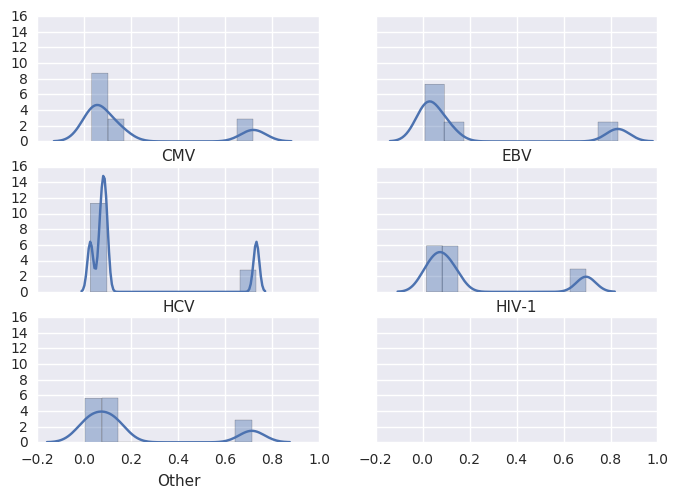

In [155]:
fig, ax = plt.subplots(3, 2, sharey=True, sharex=True)

sns.distplot(pred_prob[0,:], bins=10, ax=ax[0][0], axlabel=best_clf.classes_[0])
sns.distplot(pred_prob[1,:], bins=10, ax=ax[0][1], axlabel=best_clf.classes_[1])
sns.distplot(pred_prob[2,:], bins=10, ax=ax[1][0], axlabel=best_clf.classes_[2])
sns.distplot(pred_prob[3,:], bins=10, ax=ax[1][1], axlabel=best_clf.classes_[3])
sns.distplot(pred_prob[4,:], bins=10, ax=ax[2][0], axlabel=best_clf.classes_[4])

## Experimental data analysis

In [132]:
repertoire = pd.read_table("testdata.tsv")
repertoire.shape

(419096, 16)

In [133]:
logic = np.array(list(map(lambda x: ("*" not in x) and ("~" not in x), list(repertoire["CDR3.amino.acid.sequence"]))))
seq_vec = list(repertoire["CDR3.amino.acid.sequence"][logic])
v_vec = list(repertoire["V.gene"][logic])
len(seq_vec)

331380

In [142]:
test_X = np.array(seq2df(seq_vec, v_vec))
test_X

array([[-0.915975, -0.234946,  0.059676, ...,  1.      ,  0.      ,  0.      ],
       [-0.583293, -0.735707,  0.100468, ...,  0.      ,  0.      ,  0.      ],
       [-0.627375, -0.09016 , -0.774253, ...,  0.      ,  0.      ,  0.      ],
       ..., 
       [-0.682158, -0.252901, -0.131027, ...,  0.      ,  0.      ,  0.      ],
       [-1.014326, -0.511357, -0.415087, ...,  0.      ,  0.      ,  0.      ],
       [-1.151894, -0.466229, -0.33196 , ...,  0.      ,  0.      ,  0.      ]])

In [145]:
pred = best_clf.predict_proba(test_X[:50000,:])

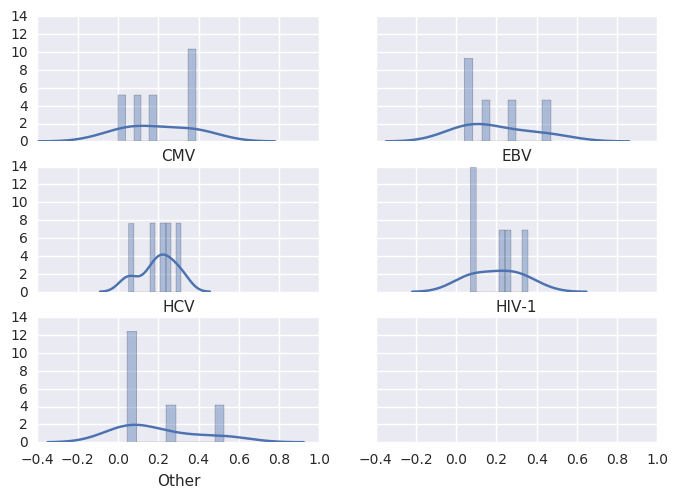

In [157]:
fig, ax = plt.subplots(3, 2, sharey=True, sharex=True)

sns.distplot(pred[0,:], bins=10, ax=ax[0][0], axlabel=best_clf.classes_[0])
sns.distplot(pred[1,:], bins=10, ax=ax[0][1], axlabel=best_clf.classes_[1])
sns.distplot(pred[2,:], bins=10, ax=ax[1][0], axlabel=best_clf.classes_[2])
sns.distplot(pred[3,:], bins=10, ax=ax[1][1], axlabel=best_clf.classes_[3])
sns.distplot(pred[4,:], bins=10, ax=ax[2][0], axlabel=best_clf.classes_[4])

In [159]:
pred[pred > .6].shape

(2023,)

In [160]:
pred[pred > .8].shape

(0,)